In [19]:
%matplotlib inline
from matplotlib import pylab as plt
import theano
from theano import tensor as T
import numpy as np

In [20]:
#create a regular grid in weight space for visualisation
wmin = -5
wmax = 5
wrange = np.linspace(wmin,wmax,300)
w = np.repeat(wrange[:,None],300,axis=1)
w = np.concatenate([[w.flatten()],[w.T.flatten()]])

In [21]:
w_grid = np.dstack(np.mgrid[wmin:wmax:300j,wmin:wmax:300j])
w_grid_flat = w_grid.reshape(300*300,2).T

In [22]:
w_grid.shape

(300, 300, 2)

In [23]:
w[...,:5]

array([[-5.        , -5.        , -5.        , -5.        , -5.        ],
       [-5.        , -4.96655518, -4.93311037, -4.89966555, -4.86622074]])

In [24]:
np.all(w.T.reshape(300,300,2)==w_grid)

True

In [25]:
np.all(w_grid_flat==w)

True

(-5, 5)

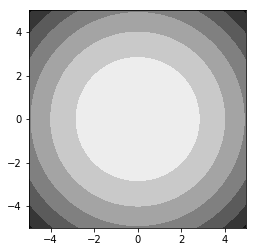

In [26]:
prior_variance = 2
logprior = -(w**2).sum(axis=0)/2/prior_variance
plt.contourf(wrange, wrange, logprior.reshape(300,300), cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])

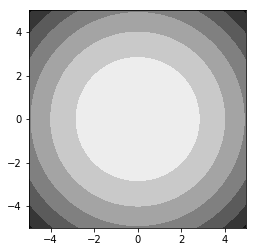

In [27]:
prior_variance = 2
logprior = -(w**2).sum(axis=0)/2/prior_variance
plt.contourf(wrange, wrange, logprior.reshape(300,300), cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

In [28]:
#generating a toy dataset with three manually selected observations
from scipy.stats import logistic
sigmoid = logistic.cdf
logsigmoid = logistic.logcdf

def likelihood(w,x,b=0,y=1):
    return logsigmoid(y*(np.dot(w.T,x) + b)).flatten()


x1 = np.array([[1.5],[1]])
x2 = np.array([[-1.5],[1]])
x3 = np.array([[0.5],[-1]])

y1=1
y2=1
y3=-1

llh1 = likelihood(w, x1, y=y1) 
llh2 = likelihood(w, x2, y=y2) 
llh3 = likelihood(w, x3, y=y3) 

In [29]:
#calculating unnormalised log posterior
#this is only for illustration
logpost = llh1 + llh2 + llh3 + logprior

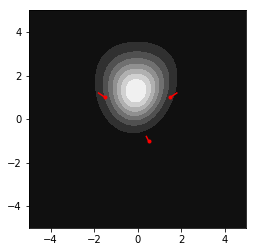

In [30]:
#plotting the real log posterior
#the red dots show the three datapoints, the small line segments shows the direction
#in which the corresponding label shifts the posterior. Positive datapoints shift the 
# posterior away from zero in the direction of the datapoint, negative datapoints shift
# away from zero, in the opposite direction.

plt.contourf(wrange,
             wrange,
             np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])

plt.plot(x1[0],x1[1],'.r')
plt.plot([x1[0],x1[0]*(1+0.2*y1)],[x1[1],x1[1]*(1+0.2*y1)],'r-')

plt.plot(x2[0],x2[1],'.r')
plt.plot([x2[0],x2[0]*(1+0.2*y2)],[x2[1],x2[1]*(1+0.2*y2)],'r-')

plt.plot(x3[0],x3[1],'.r')
plt.plot([x3[0],x3[0]*(1+0.2*y3)],[x3[1],x3[1]*(1+0.2*y3)],'r-');

## Fitting an approximate posterior

This part is for the actual GAN stuff. Here we define the generator and the discriminator networks in Lasagne, and code up the two loss functions in theano.

In [31]:
from lasagne.utils import floatX

from lasagne.layers import (
    InputLayer,
    DenseLayer,
    NonlinearityLayer)
from lasagne.nonlinearities import sigmoid

#defines a 'generator' network
def build_G(input_var=None, num_z = 3):
    
    network = InputLayer(input_var=input_var, shape=(None, num_z))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=2, nonlinearity=None)
    
    return network

#defines the 'discriminator network'
def build_D(input_var=None):

    network = InputLayer(input_var=input_var, shape = (None, 2))
    
    network = DenseLayer(incoming = network, num_units=10)
    
    network = DenseLayer(incoming = network, num_units=20)
    
    network = DenseLayer(incoming = network, num_units=1, nonlinearity=None)
    
    normalised = NonlinearityLayer(incoming = network, nonlinearity = sigmoid)
    
    return { 'unnorm':network, 'norm':normalised }

/home/tiao/.virtualenvs/implicit/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [32]:
from lasagne.layers import get_output, get_all_params
from theano.printing import debugprint
from lasagne.updates import adam
from theano.tensor.shared_randomstreams import RandomStreams

#variables for input (design matrix), output labels, GAN noise variable, weights
x_var = T.matrix('design matrix')
y_var = T.vector('labels')
z_var = T.matrix('GAN noise')
w_var = T.matrix('weights')

#theano variables for things like batchsize, learning rate, etc.
batchsize_var = T.scalar('batchsize', dtype='int32')
prior_variance_var = T.scalar('prior variance')
learningrate_var = T.scalar('learning rate')

#random numbers for sampling from the prior or from the GAN
srng = RandomStreams(seed=1337)
z_rnd = srng.normal((batchsize_var,3))
prior_rnd = srng.normal((batchsize_var,2))

#instantiating the G and D networks
generator = build_G(z_var)
discriminator = build_D()

#these expressions are random samples from the generator and the prior, respectively
samples_from_grenerator = get_output(generator, z_rnd)
samples_from_prior = prior_rnd*T.sqrt(prior_variance_var)

#discriminator output for synthetic samples, both normalised and unnormalised (after/before sigmoid)
D_of_G = get_output(discriminator['norm'], inputs=samples_from_grenerator)
s_of_G = get_output(discriminator['unnorm'], inputs=samples_from_grenerator)

#discriminator output for real samples from the prior
D_of_prior = get_output(discriminator['norm'], inputs=samples_from_prior)

#loss of discriminator - simple binary cross-entropy loss
loss_D = -T.log(D_of_G).mean() - T.log(1-D_of_prior).mean()

#log likelihood for each synthetic w sampled from the generator
log_likelihood = T.log(
    T.nnet.sigmoid(
        (y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * samples_from_grenerator.dimshuffle('x', 1, 0))).sum(1)
    )
).sum(0).mean()

#loss for G is the sum of unnormalised discriminator output and the negative log likelihood
loss_G = s_of_G.mean() - log_likelihood

#compiling theano functions:
evaluate_generator = theano.function(
    [z_var],
    get_output(generator),
    allow_input_downcast=True
)

sample_generator = theano.function(
    [batchsize_var],
    samples_from_grenerator,
    allow_input_downcast=True,
)

sample_prior = theano.function(
    [prior_variance_var, batchsize_var],
    samples_from_prior,
    allow_input_downcast=True
)

params_D = get_all_params(discriminator['norm'], trainable=True)

updates_D = adam(
    loss_D,
    params_D,
    learning_rate = learningrate_var
)

train_D = theano.function(
    [learningrate_var, batchsize_var, prior_variance_var],
    loss_D,
    updates = updates_D,
    allow_input_downcast = True
)

params_G = get_all_params(generator, trainable=True)

updates_G = adam(
    loss_G,
    params_G,
    learning_rate = learningrate_var
)

train_G = theano.function(
    [x_var, y_var, learningrate_var, batchsize_var],
    loss_G,
    updates = updates_G,
    allow_input_downcast = True
)

evaluate_discriminator = theano.function(
    [w_var],
    get_output([discriminator['unnorm'],discriminator['norm']],w_var),
    allow_input_downcast = True
)

#this is to evaluate the log-likelihood of an arbitrary set of w
llh_for_w = T.nnet.sigmoid((y_var.dimshuffle(0,'x','x')*(x_var.dimshuffle(0,1,'x') * w_var.dimshuffle('x', 1, 0))).sum(1))

evaluate_loglikelihood = theano.function(
        [x_var, y_var, w_var],
        llh_for_w,
        allow_input_downcast = True
    )

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


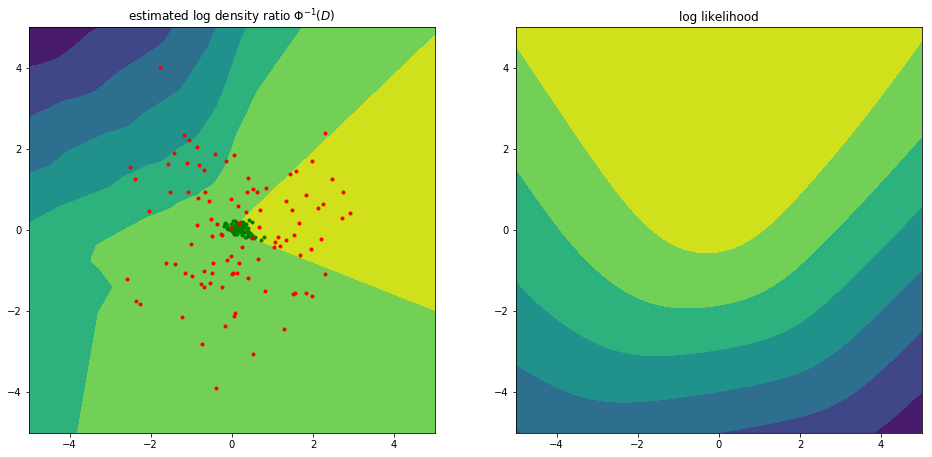

In [33]:
plt.figure(figsize=(16,8))


plt.subplot(1,2,1)
plt.contourf(wrange, wrange, evaluate_discriminator(w.T)[0].reshape(300,300).T)

W = sample_generator(100)
plt.plot(W[:,0],W[:,1],'g.')

W = sample_prior(prior_variance, 100)
plt.plot(W[:,0],W[:,1],'r.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('estimated log density ratio $\Phi^{-1}(D)$')

plt.subplot(1,2,2)
plt.contourf(wrange, wrange, (llh1+llh2+llh3).reshape(300,300).T)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

plt.title('log likelihood');

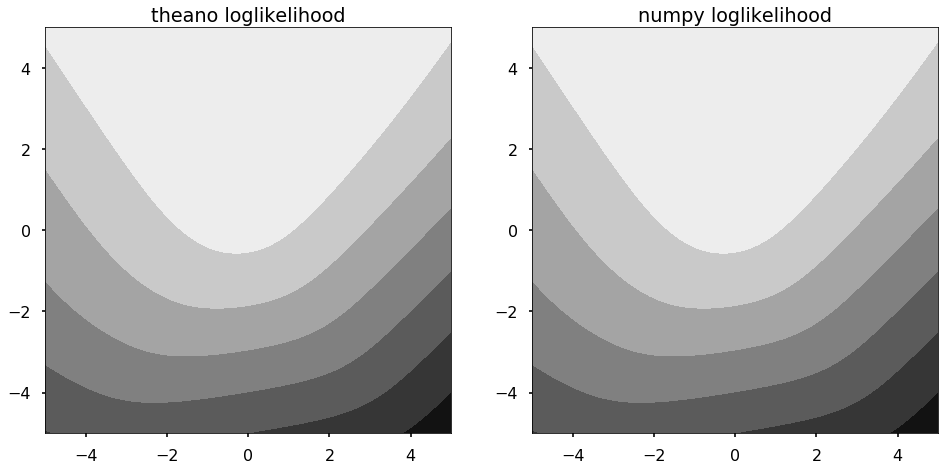

In [9]:
#checking that theano and numpy give the same likelihoods
import seaborn as sns
sns.set_context('poster')

X_train = np.concatenate([x1,x2,x3],axis=1).T
y_train = np.array([y1,y2,y3])
llh_theano = evaluate_loglikelihood(X_train, y_train, w.T)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.contourf(wrange, wrange ,np.log(llh_theano).sum(0).reshape(300,300).T,cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('theano loglikelihood')

plt.subplot(1,2,2)
plt.contourf(wrange, wrange, (llh1+llh2+llh3).reshape(300,300).T,cmap='gray');
plt.axis('square');
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('numpy loglikelihood')

assert np.allclose(llh1+llh2+llh3,np.log(llh_theano).sum(0))

In [10]:
batchsize = 200
KARPATHY_CONSTANT = 3e-4
learning_rate = KARPATHY_CONSTANT*10

prior_variance = 2
# train discriminator for some time before starting iterative process
%timeit -n 300 train_D(learning_rate, batchsize, prior_variance)
# print initial values of training errors
print (train_D(0, 100, prior_variance))
print (train_G(X_train, y_train, 0, batchsize))
for i in range(200):
    %timeit -n 50 train_D(learning_rate, batchsize, prior_variance)
    print (train_D(0, 100, prior_variance))
    print (train_G(X_train, y_train, 0, 100))
    train_G(X_train, y_train, learning_rate, batchsize)

756 µs ± 271 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
0.33257354666094224
4.996102628755116
490 µs ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.2119455387013967
4.1202309895028835
554 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.3581621228462506
4.707070363772413
525 µs ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.21017178628830308
4.276304144298293
578 µs ± 103 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.40397309168350565
4.372633122086429
1.03 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.46383786347060996
4.2827275263065765
532 µs ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.4742954938839633
4.3077686017458054
531 µs ± 84.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.4121499447379206
4.397708586401626
593 µs ± 156 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.44319494364792195
3.980595081088458
1.08 ms ± 449 µs per loop (mean 

607 µs ± 62.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.8046362052484096
1.9086013477667225
553 µs ± 43.6 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9325364646910803
1.9109967613404208
511 µs ± 53.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
1.0304139762238786
1.9654525015937858
505 µs ± 57.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
1.0540401463614057
1.9582530556159827
562 µs ± 77.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.914125377935025
1.8530085305028012
472 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9448266113197814
1.9636818919264836
528 µs ± 70.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.963835996295888
1.894341290727306
797 µs ± 237 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.8615783954534084
1.9528007843738875
472 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.7910335704428098
1.9388852726528625
501 µs ± 58.2 µs per loop (mean ± 

583 µs ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9406141294930126
1.9025527526374169
501 µs ± 82 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
1.060407851595865
1.8790415774849558
584 µs ± 186 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9263146702991807
1.9159754127656088
464 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.902627280762216
1.8929628711058266
559 µs ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.940825833072022
1.9478878029088262
521 µs ± 76.3 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9345100510488324
1.9208407501589857
535 µs ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
1.0616573458438032
1.893844467893682
560 µs ± 73 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9259801183968952
1.9219868429525562
593 µs ± 122 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
0.9248751926178794
1.8443098633578021
519 µs ± 96.8 µs per loop (mean ± std.

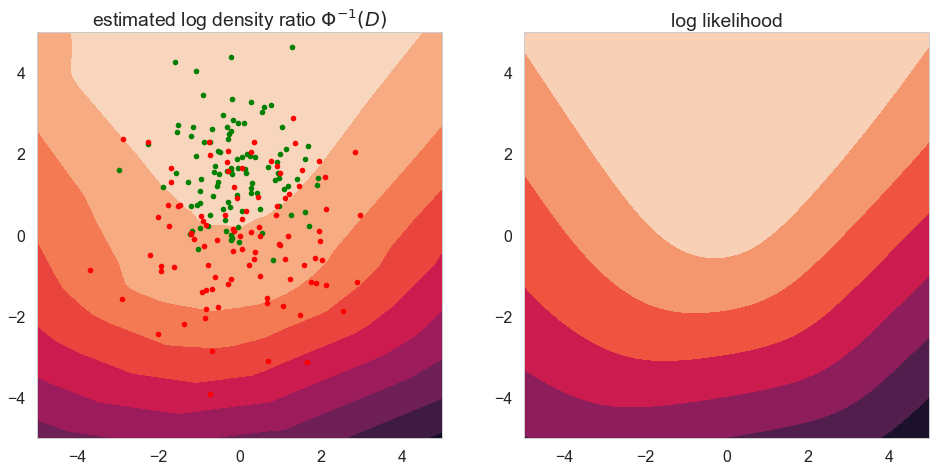

In [16]:
plt.figure(figsize=(16,8))


plt.subplot(1,2,1)
plt.contourf(wrange, wrange, evaluate_discriminator(w.T)[0].reshape(300,300).T)

W = sample_generator(100)
plt.plot(W[:,0],W[:,1],'g.')

W = sample_prior(prior_variance, 100)
plt.plot(W[:,0],W[:,1],'r.')
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax])
plt.title('estimated log density ratio $\Phi^{-1}(D)$')

plt.subplot(1,2,2)
plt.contourf(wrange, wrange, (llh1+llh2+llh3).reshape(300,300).T)
plt.axis('square')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);

plt.title('log likelihood');

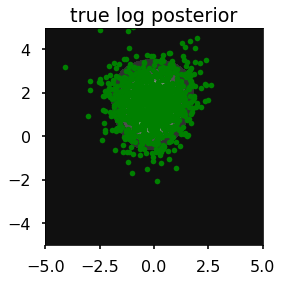

In [12]:
plt.contourf(wrange, wrange, np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
W = sample_generator(1000)
plt.plot(W[:,0],W[:,1],'.g')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.title('true log posterior');


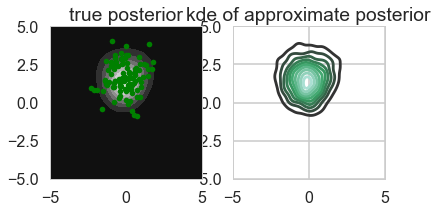

In [13]:
sns.set_style('whitegrid')
plt.subplot(1,2,2)

W = sample_generator(5000)
plot = sns.kdeplot(W[:,0],W[:,1])
plt.axis('square')
plot.set(xlim=(wmin,wmax))
plot.set(ylim=(wmin,wmax))
plt.title('kde of approximate posterior')

plt.subplot(1,2,1)
plt.contourf(wrange, wrange, np.exp(logpost.reshape(300,300).T),cmap='gray');
plt.axis('square');
W = sample_generator(100)
plt.plot(W[:,0],W[:,1],'.g')
plt.xlim([wmin,wmax])
plt.ylim([wmin,wmax]);
plt.title('true posterior');